# Import dataset

In [1]:
import pandas as pd
import pm4py
from label_functions import *
import editdistance
from functions import *


# import data
def import_xes(file_path):
    event_log = pm4py.read_xes(file_path)
    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))
    return event_log

event_log = import_xes("data/Hospital_log.xes.gz")
print(type(event_log))
print(event_log)

parsing log, completed traces ::   0%|          | 0/1143 [00:00<?, ?it/s]

Start activities: {'1e consult poliklinisch': 71, 'inwend.geneesk.  korte kaart kosten-out': 8, 'verlosk.-gynaec. korte kaart kosten-out': 198, 'vervolgconsult poliklinisch': 234, 'verlosk.-gynaec.   jaarkaart kosten-out': 122, 'cytologisch onderzoek - ectocervix -': 28, 'echografie  - genitalia interna': 44, 'aanname laboratoriumonderzoek': 225, 'ligdagen - alle spec.beh.kinderg.-reval.': 39, 'telefonisch consult': 15, 'behandeltijd - eenheid t3 - megavolt': 1, 'ct abdomen': 2, 'behandeltijd - eenheid t2 - megavolt': 1, 'thorax': 12, 'e.c.g.      - elektrocardiografie': 63, 'cytologisch onderzoek - vagina -': 12, 'mammografie thoraxwand': 3, 'histologisch onderzoek - biopten nno': 19, 'dagverpleging - alle spec.beh.kind.-rev.': 5, 'inwend.geneesk.    jaarkaart kosten-out': 1, 'coupe ter inzage': 19, 'immunopathologisch onderzoek': 10, 'vagina      - scopie incl.evt.vulvabiops': 3, 'punctie tbv cytologisch onderzoek door p': 3, 'cytologisch onderzoek - buiktumorpunctie': 1, 'vrw.gesl.o

## Covert to log and sort based on timestamp. Convert back to dataframe to apply label function 1

In [2]:
from pm4py.objects.log.util import sorting

# Convert to event log before sorting.
log = pm4py.convert_to_event_log(event_log)
# Sort the event log in ascending order by timestamp
log_sorted = sorting.sort_timestamp(log, timestamp_key="time:timestamp", reverse_sort=False)

# Check the first trace start time to verify sorting
print(f"First trace start time: {log_sorted[0][0]['time:timestamp']}")
print(f"Last trace start time: {log_sorted[-1][0]['time:timestamp']}")

First trace start time: 2005-01-03 00:00:00+00:00
Last trace start time: 2008-03-20 00:00:00+00:00


In [3]:
# Now convert the dataframe to an event log
log_df = pm4py.convert_to_dataframe(log_sorted)
log_df.head(10)

,org:group,Number of executions,Specialism code,concept:name,Producer code,Section,Activity code,time:timestamp,lifecycle:transition,case:End date,...,case:Treatment code:14,case:Treatment code:15,case:Diagnosis:15,case:Diagnosis:14,case:Diagnosis:11,case:Diagnosis:13,case:Diagnosis:12,case:Diagnosis code:14,case:Diagnosis code:13,case:Diagnosis code:15
0,Radiotherapy,1,61,1e consult poliklinisch,SRTH,Section 5,410100,2005-01-03 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Radiotherapy,1,61,administratief tarief - eerste pol,SRTH,Section 5,419100,2005-01-03 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nursing ward,1,7,verlosk.-gynaec. korte kaart kosten-out,SGEH,Section 2,10107,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Obstetrics & Gynaecology clinic,1,7,echografie - genitalia interna,SGEC,Section 2,339486E,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nursing ward,1,7,1e consult poliklinisch,SGEH,Section 2,410100,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Nursing ward,1,7,administratief tarief - eerste pol,SGEH,Section 2,419100,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Radiotherapy,1,61,simulator - gebruik voor aanvang megavol,RATH,Section 5,390520,2005-01-24 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Radiotherapy,1,61,behandeltijd - eenheid t3 - megavolt,RATH,Section 5,390003,2005-01-31 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Radiotherapy,1,61,teletherapie - megavolt fotonen bestrali,RATH,Section 5,390550,2005-01-31 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,General Lab Clinical Chemistry,1,86,aanname laboratoriumonderzoek,CRLA,Section 4,370000,2005-02-15 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Label Function 1

In [6]:
def label_function (log_df, required_activities):

    # Filter log to retain only traces with required activities
    filtered_df = pm4py.filtering.filter_event_attribute_values(
        log_df,
        attribute_key='concept:name',
        values=required_activities,
        level='case',
        retain=True,
        case_id_key='case:concept:name'
    )
    
    # Identify case IDs in the filtered DataFrame (these cases are normal)
    normal_cases = filtered_df['case:concept:name'].unique()
    
    # Add a 'deviant' column to label cases
    log_df['case:Deviant'] = log_df['case:concept:name'].apply(lambda x: 'negative' if x in normal_cases else 'positive')
    
    return log_df


# Define required activities for this rule
required_activities_f1 = ['ca-19.9 tumormarker', 'ca-125 mbv meia']

log_df = label_function(log_df, required_activities_f1)
log_df.head(10)

,org:group,Number of executions,Specialism code,concept:name,Producer code,Section,Activity code,time:timestamp,lifecycle:transition,case:End date,...,case:Treatment code:15,case:Diagnosis:15,case:Diagnosis:14,case:Diagnosis:11,case:Diagnosis:13,case:Diagnosis:12,case:Diagnosis code:14,case:Diagnosis code:13,case:Diagnosis code:15,case:Deviant
0,Radiotherapy,1,61,1e consult poliklinisch,SRTH,Section 5,410100,2005-01-03 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive
1,Radiotherapy,1,61,administratief tarief - eerste pol,SRTH,Section 5,419100,2005-01-03 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive
2,Nursing ward,1,7,verlosk.-gynaec. korte kaart kosten-out,SGEH,Section 2,10107,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive
3,Obstetrics & Gynaecology clinic,1,7,echografie - genitalia interna,SGEC,Section 2,339486E,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive
4,Nursing ward,1,7,1e consult poliklinisch,SGEH,Section 2,410100,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive
5,Nursing ward,1,7,administratief tarief - eerste pol,SGEH,Section 2,419100,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive
6,Radiotherapy,1,61,simulator - gebruik voor aanvang megavol,RATH,Section 5,390520,2005-01-24 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive
7,Radiotherapy,1,61,behandeltijd - eenheid t3 - megavolt,RATH,Section 5,390003,2005-01-31 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive
8,Radiotherapy,1,61,teletherapie - megavolt fotonen bestrali,RATH,Section 5,390550,2005-01-31 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive
9,General Lab Clinical Chemistry,1,86,aanname laboratoriumonderzoek,CRLA,Section 4,370000,2005-02-15 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive


## Check class balance (optional)

case:Deviant
positive    683
negative    460
Name: count, dtype: int64


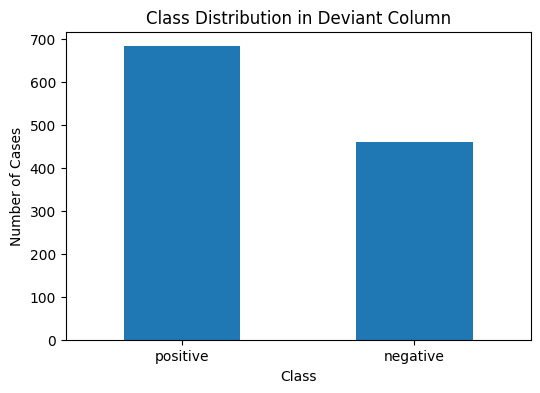

In [7]:
import matplotlib.pyplot as plt

# Count the number of normal and deviant cases
class_counts = log_df[['case:concept:name', 'case:Deviant']].drop_duplicates()['case:Deviant'].value_counts()
print (class_counts)
# Plot the class distribution
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar')
plt.title('Class Distribution in Deviant Column')
plt.xlabel('Class')
plt.ylabel('Number of Cases')
plt.xticks(rotation=0)
plt.show()

## Convert to log and apply train test split

In [8]:
log = pm4py.convert_to_event_log(log_df)
# Split cases into training and testing sets based on 80/20 split
train_log, test_log = pm4py.split_train_test(log, train_percentage=0.8)
train_log_df = pm4py.convert_to_dataframe(train_log)
test_log_df = pm4py.convert_to_dataframe(test_log)
print("Train_log size: {}".format(len(train_log)))
print("Test log size: {}".format(len(test_log)))

# Prefix extraction (k=21 ; g=5) sequence encoding and clustering

In [ ]:
# # Group and extract prefixes from training traces
# train_traces = train_log_df.groupby('case:concept:name')['concept:name'].apply(list)
# train_prefixes = train_traces.apply(lambda x: extract_prefixes(x)).explode()
# train_prefixes_df = pd.DataFrame(train_prefixes).reset_index(names='case:concept:name')
# train_prefixes_df.rename(columns={'concept:name': 'prefix'}, inplace=True)


In [45]:
def extract_prefixes_and_payloads(log_df, event_column='concept:name', data_attributes=None, max_len=21, step=5):
    """
    Extracts prefixes from the event log data based on specified step size and maximum length,
    and also extracts the latest payloads for specified data attributes at each prefix length.

    Parameters:
    - log_df (DataFrame): The event log data with 'case:concept:name' and event column.
    - event_column (str): The column name in log_df containing event names.
    - data_attributes (list): List of data attribute column names to extract latest payloads.
    - max_len (int): Maximum length of prefixes to extract.
    - step (int): Step size for prefix extraction.

    Returns:
    - DataFrame: DataFrame with 'case:concept:name', extracted prefixes, and latest payloads for each attribute.
    """
    
    # Extract prefixes for the specified event column
    # Group by 'case:concept:name' and extract prefixes for each trace
    traces = log_df.groupby('case:concept:name')[event_column].apply(list)
    prefixes = traces.apply(lambda trace: [trace[:i] for i in range(1, max_len + 1, step) if i <= len(trace)]).explode()
    
    # Convert to DataFrame and reset index
    prefixes_df = pd.DataFrame(prefixes).reset_index(names='case:concept:name')
    prefixes_df.rename(columns={event_column: 'prefix'}, inplace=True)
    
    # Extract latest payloads for each attribute in data_attributes and add to prefixes
    if data_attributes:
        for attribute in data_attributes:
            # Group by 'case:concept:name' and extract lists of each attribute's values
            trace_payloads = log_df.groupby('case:concept:name')[attribute].apply(list)
            
            # Extract payload prefixes and keep only the last element of each
            payload_prefixes = trace_payloads.apply(lambda trace: [trace[:i] for i in range(1, max_len + 1, step) if i <= len(trace)]).explode()
            payload_prefixes = payload_prefixes.apply(lambda x: x[-1] if isinstance(x, list) and x else None)
            
            # Add payload prefixes to prefixes_df by matching the indices
            prefixes_df[attribute] = payload_prefixes.values

    # Fill missing values with 'Missing' and ensure all values are strings
    prefixes_df = prefixes_df.fillna('Missing')
    prefixes_df[data_attributes].astype(str)
    return prefixes_df

In [75]:
# Extract prefixes and latest event payload
data_attributes = ['case:Diagnosis code', 'case:Treatment code']
train_prefixes_and_payloads_df = extract_prefixes_and_payloads(train_log_df, event_column='concept:name', data_attributes=data_attributes)

# Display the resulting DataFrame
train_prefixes_and_payloads_df.head(10)

,case:concept:name,prefix,case:Diagnosis code,case:Treatment code
0,00000000,[1e consult poliklinisch],M13,103.0
1,00000000,"[1e consult poliklinisch, administratief tarie...",M13,103.0
2,00000000,"[1e consult poliklinisch, administratief tarie...",M13,103.0
3,00000000,"[1e consult poliklinisch, administratief tarie...",M13,103.0
4,00000000,"[1e consult poliklinisch, administratief tarie...",M13,103.0
5,00000001,[inwend.geneesk. korte kaart kosten-out],822,3101.0
6,00000001,"[inwend.geneesk. korte kaart kosten-out, 1e c...",822,3101.0
7,00000001,"[inwend.geneesk. korte kaart kosten-out, 1e c...",822,3101.0
8,00000001,"[inwend.geneesk. korte kaart kosten-out, 1e c...",822,3101.0
9,00000001,"[inwend.geneesk. korte kaart kosten-out, 1e c...",822,3101.0


In [76]:
import numpy as np
from sklearn.cluster import DBSCAN
import editdistance

# Create a mapping of unique event names to integer IDs
unique_events = log_df['concept:name'].unique()
event_to_id = {event: idx for idx, event in enumerate(unique_events)}

# Encode sequences using numeric IDs
def sequence_encode_with_ids(prefixes_df, event_to_id):
    # Convert each prefix to a sequence of numeric IDs
    sequences = prefixes_df.apply(lambda x: [event_to_id[event] for event in x]).tolist()
    return sequences

sequences = sequence_encode_with_ids(train_prefixes_and_payloads_df['prefix'], event_to_id)
train_prefixes_and_payloads_df['encoded_sequence'] = sequences

In [77]:

# Compute distance matrix using Levenshtein (edit) distance
def compute_distance_matrix(sequences):
    num_sequences = len(sequences)
    distance_matrix = np.zeros((num_sequences, num_sequences))

    # Calculate the Levenshtein distance between each pair of sequences
    for i in range(num_sequences):
        for j in range(i + 1, num_sequences):
            distance = editdistance.eval(sequences[i], sequences[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # Symmetric matrix

    return distance_matrix

distance_matrix = compute_distance_matrix(sequences)

In [84]:

# Apply DBSCAN on the distance matrix
def dbscan_clustering(distance_matrix, eps=0.125, min_samples=4):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = db.fit_predict(distance_matrix)
    return labels


cluster_labels = dbscan_clustering(distance_matrix)
train_prefixes_and_payloads_df['cluster'] = cluster_labels
train_encoded_df = train_prefixes_and_payloads_df.copy()
train_encoded_df.head(10)

,case:concept:name,prefix,case:Diagnosis code,case:Treatment code,encoded_sequence,cluster
0,00000000,[1e consult poliklinisch],M13,103.0,[0],0
1,00000000,"[1e consult poliklinisch, administratief tarie...",M13,103.0,"[0, 1, 2, 3, 0, 1]",-1
2,00000000,"[1e consult poliklinisch, administratief tarie...",M13,103.0,"[0, 1, 2, 3, 0, 1, 4, 5, 6, 7, 7]",-1
3,00000000,"[1e consult poliklinisch, administratief tarie...",M13,103.0,"[0, 1, 2, 3, 0, 1, 4, 5, 6, 7, 7, 8, 9, 10, 11...",-1
4,00000000,"[1e consult poliklinisch, administratief tarie...",M13,103.0,"[0, 1, 2, 3, 0, 1, 4, 5, 6, 7, 7, 8, 9, 10, 11...",-1
5,00000001,[inwend.geneesk. korte kaart kosten-out],822,3101.0,[31],1
6,00000001,"[inwend.geneesk. korte kaart kosten-out, 1e c...",822,3101.0,"[31, 0, 1, 2, 32, 1]",-1
7,00000001,"[inwend.geneesk. korte kaart kosten-out, 1e c...",822,3101.0,"[31, 0, 1, 2, 32, 1, 32, 16, 7, 7, 7]",-1
8,00000001,"[inwend.geneesk. korte kaart kosten-out, 1e c...",822,3101.0,"[31, 0, 1, 2, 32, 1, 32, 16, 7, 7, 7, 33, 34, ...",-1
9,00000001,"[inwend.geneesk. korte kaart kosten-out, 1e c...",822,3101.0,"[31, 0, 1, 2, 32, 1, 32, 16, 7, 7, 7, 33, 34, ...",-1


## Label prefixes

In [85]:
# Map 'deviant' labels from event_log to train_prefixes_df using 'case:concept:name'
label_map = log_df[['case:concept:name', 'case:Deviant']].drop_duplicates().set_index('case:concept:name')['case:Deviant']
train_encoded_df['case:Deviant'] = train_encoded_df['case:concept:name'].map(label_map)

train_encoded_df.head(10)

,case:concept:name,prefix,case:Diagnosis code,case:Treatment code,encoded_sequence,cluster,case:Deviant
0,00000000,[1e consult poliklinisch],M13,103.0,[0],0,positive
1,00000000,"[1e consult poliklinisch, administratief tarie...",M13,103.0,"[0, 1, 2, 3, 0, 1]",-1,positive
2,00000000,"[1e consult poliklinisch, administratief tarie...",M13,103.0,"[0, 1, 2, 3, 0, 1, 4, 5, 6, 7, 7]",-1,positive
3,00000000,"[1e consult poliklinisch, administratief tarie...",M13,103.0,"[0, 1, 2, 3, 0, 1, 4, 5, 6, 7, 7, 8, 9, 10, 11...",-1,positive
4,00000000,"[1e consult poliklinisch, administratief tarie...",M13,103.0,"[0, 1, 2, 3, 0, 1, 4, 5, 6, 7, 7, 8, 9, 10, 11...",-1,positive
5,00000001,[inwend.geneesk. korte kaart kosten-out],822,3101.0,[31],1,positive
6,00000001,"[inwend.geneesk. korte kaart kosten-out, 1e c...",822,3101.0,"[31, 0, 1, 2, 32, 1]",-1,positive
7,00000001,"[inwend.geneesk. korte kaart kosten-out, 1e c...",822,3101.0,"[31, 0, 1, 2, 32, 1, 32, 16, 7, 7, 7]",-1,positive
8,00000001,"[inwend.geneesk. korte kaart kosten-out, 1e c...",822,3101.0,"[31, 0, 1, 2, 32, 1, 32, 16, 7, 7, 7, 33, 34, ...",-1,positive
9,00000001,"[inwend.geneesk. korte kaart kosten-out, 1e c...",822,3101.0,"[31, 0, 1, 2, 32, 1, 32, 16, 7, 7, 7, 33, 34, ...",-1,positive


# Test

## Prepare the test data

In [87]:
# Extract prefixes and latest event payload
data_attributes = ['case:Diagnosis code', 'case:Treatment code']
test_prefixes_and_payloads_df = extract_prefixes_and_payloads(test_log_df, event_column='concept:name', data_attributes=data_attributes)

# Encode sequences
test_sequences = sequence_encode_with_ids(test_prefixes_and_payloads_df['prefix'], event_to_id)
test_prefixes_and_payloads_df['encoded_sequence'] = test_sequences

# Map 'deviant' labels from event_log to train_prefixes_df using 'case:concept:name'
test_prefixes_and_payloads_df['case:Deviant'] = test_prefixes_and_payloads_df['case:concept:name'].map(label_map)

# Display the resulting DataFrame
test_encoded_df = test_prefixes_and_payloads_df.copy()
test_encoded_df.head(10)

,case:concept:name,prefix,case:Diagnosis code,case:Treatment code,encoded_sequence,case:Deviant
0,00000010,[verlosk.-gynaec. korte kaart kosten-out],M13,113.0,[2],negative
1,00000010,"[verlosk.-gynaec. korte kaart kosten-out, echo...",M13,113.0,"[2, 3, 85, 98, 149, 102]",negative
2,00000010,"[verlosk.-gynaec. korte kaart kosten-out, echo...",M13,113.0,"[2, 3, 85, 98, 149, 102, 7, 7, 7, 74, 75]",negative
3,00000010,"[verlosk.-gynaec. korte kaart kosten-out, echo...",M13,113.0,"[2, 3, 85, 98, 149, 102, 7, 7, 7, 74, 75, 76, ...",negative
4,00000010,"[verlosk.-gynaec. korte kaart kosten-out, echo...",M13,113.0,"[2, 3, 85, 98, 149, 102, 7, 7, 7, 74, 75, 76, ...",negative
5,00000012,[verlosk.-gynaec. korte kaart kosten-out],Missing,Missing,[2],negative
6,00000012,"[verlosk.-gynaec. korte kaart kosten-out, hist...",Missing,Missing,"[2, 101, 102, 7, 7, 7]",negative
7,00000012,"[verlosk.-gynaec. korte kaart kosten-out, hist...",Missing,Missing,"[2, 101, 102, 7, 7, 7, 74, 75, 76, 8, 9]",negative
8,00000012,"[verlosk.-gynaec. korte kaart kosten-out, hist...",Missing,Missing,"[2, 101, 102, 7, 7, 7, 74, 75, 76, 8, 9, 10, 7...",negative
9,00000012,"[verlosk.-gynaec. korte kaart kosten-out, hist...",Missing,Missing,"[2, 101, 102, 7, 7, 7, 74, 75, 76, 8, 9, 10, 7...",negative


## Encode categorical attributes on train and test sets

In [91]:
from sklearn.preprocessing import LabelEncoder

# Define the feature columns (data attributes) and target column
feature_columns = ['case:Diagnosis code', 'case:Treatment code']
target_column = 'case:Deviant'

# Combine the data attribute columns from train and test dataframes
combined_df = pd.concat([train_encoded_df[feature_columns], test_encoded_df[feature_columns]], axis=0)

# Initialize LabelEncoders for each feature column and fit on combined data
le_dict = {col: LabelEncoder() for col in feature_columns}

# Initialize a dictionary to store the trained classifiers for each cluster
cluster_classifiers = {}
le_dict = {col: LabelEncoder() for col in feature_columns}  # Create a LabelEncoder for each feature column

# Apply encoding to the combined DataFrame, then update train and test sets
for col in feature_columns:
    # Fit encoder on the combined column
    combined_df[col] = combined_df[col].astype(str)  # Convert to string if necessary
    le_dict[col].fit(combined_df[col])
    
    # Transform train and test columns with the fitted encoder
    train_encoded_df[col] = le_dict[col].transform(train_encoded_df[col].astype(str))
    test_encoded_df[col] = le_dict[col].transform(test_encoded_df[col].astype(str))
    

# Initialize global target label encoder
target_encoder = LabelEncoder()
train_encoded_df[target_column] = target_encoder.fit_transform(train_encoded_df[target_column])
test_encoded_df[target_column] = target_encoder.fit_transform(test_encoded_df[target_column])


# Train a classifier for each cluster

In [95]:
# Loop over each unique cluster label to train a classifier for each cluster
for cluster_label in train_encoded_df['cluster'].unique():
    if cluster_label == -1:
        continue  # Skip noise cluster

    # Filter data for the current cluster
    cluster_data = train_encoded_df[train_encoded_df['cluster'] == cluster_label]
    X_train = cluster_data[feature_columns]
    y_train = cluster_data[target_column]

    # Train a decision tree classifier for the current cluster
    clf = DecisionTreeClassifier(max_depth=3, random_state=0)
    clf.fit(X_train, y_train)
    cluster_classifiers[cluster_label] = clf

# Display trained classifiers
print("\nTrained classifiers for each cluster:")
for cluster_label, clf in cluster_classifiers.items():
    print(f"Cluster {cluster_label}: Decision Tree with depth {clf.get_depth()}")


Trained classifiers for each cluster:
Cluster 0: Decision Tree with depth 3
Cluster 1: Decision Tree with depth 2
Cluster 2: Decision Tree with depth 3
Cluster 3: Decision Tree with depth 1
Cluster 4: Decision Tree with depth 1
Cluster 5: Decision Tree with depth 1
Cluster 6: Decision Tree with depth 1
Cluster 7: Decision Tree with depth 3
Cluster 8: Decision Tree with depth 3
Cluster 9: Decision Tree with depth 3
Cluster 10: Decision Tree with depth 3
Cluster 11: Decision Tree with depth 3
Cluster 12: Decision Tree with depth 3
Cluster 13: Decision Tree with depth 2
Cluster 14: Decision Tree with depth 1
Cluster 15: Decision Tree with depth 3
Cluster 16: Decision Tree with depth 0
Cluster 17: Decision Tree with depth 1
Cluster 18: Decision Tree with depth 3
Cluster 19: Decision Tree with depth 0
Cluster 20: Decision Tree with depth 0
Cluster 21: Decision Tree with depth 2
Cluster 22: Decision Tree with depth 2
Cluster 23: Decision Tree with depth 2
Cluster 24: Decision Tree with dept

In [96]:
# Pre-compute the encoded prefixes for each cluster
# Using pre-computed encoded sequences directly
cluster_prefixes_encoded = {}
for cluster_label in train_encoded_df['cluster'].unique():
    # Skip noise (-1 in DBSCAN)
    if cluster_label == -1:
        continue
    # Access pre-encoded sequences for the current cluster
    cluster_data = train_encoded_df[train_encoded_df['cluster'] == cluster_label]
    cluster_prefixes_encoded[cluster_label] = cluster_data['encoded_sequence'].tolist()


# Find the closest prefix in any cluster to each test sequence
def find_closest_prefix_across_clusters(test_sequence, cluster_prefixes_encoded):
    min_distance = float('inf')
    closest_cluster = None

    # Check each prefix across all clusters
    for cluster_label, train_encoded_df in cluster_prefixes_encoded.items():
        for prefix in train_encoded_df:
            distance = editdistance.eval(test_sequence, prefix)
            if distance < min_distance:
                min_distance = distance
                closest_cluster = cluster_label

    return closest_cluster, min_distance

In [106]:
# Initialize predictions list
predictions = []
for index, test_sequence in enumerate(test_encoded_df['encoded_sequence']):
    # Find the closest cluster to the current test sequence
    closest_cluster, distance = find_closest_prefix_across_clusters(test_sequence, cluster_prefixes_encoded)

    # Extract the last event's payload data as test features
    X_test = test_encoded_df.loc[index, feature_columns].to_frame().T.astype(str)

    # Use the classifier for the closest cluster to predict
    clf = cluster_classifiers[closest_cluster]
    y_pred_encoded = clf.predict(X_test)[0]

    # Decode the predicted label to original string form
    y_pred = target_encoder.inverse_transform([y_pred_encoded])[0]
    y_pred_proba = clf.predict_proba(X_test)[0][y_pred_encoded] if clf.predict_proba(X_test).size > 1 else 1.0

    # Decode the true class label for this case
    true_class_encoded = test_encoded_df.loc[index, 'case:Deviant']
    true_class = target_encoder.inverse_transform([true_class_encoded])[0]

    predictions.append({
        'case:concept:name': test_encoded_df.loc[index, 'case:concept:name'],
        'closest_cluster': closest_cluster,
        'distance': distance,
        'predicted_class': y_pred,
        'true_class': true_class,
        'predicted_probability': y_pred_proba
    })

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions)
predictions_df

,case:concept:name,closest_cluster,distance,predicted_class,true_class,predicted_probability
0,00000010,2,0,negative,negative,0.570000
1,00000010,2,5,negative,negative,0.570000
2,00000010,9,5,negative,negative,0.685714
3,00000010,10,5,negative,negative,0.718750
4,00000010,11,5,negative,negative,0.718750
...,...,...,...,...,...,...
883,00001142,15,0,positive,positive,0.644444
884,00001142,26,0,positive,positive,0.600000
885,00001142,27,0,positive,positive,0.600000
886,00001142,28,0,positive,positive,0.600000


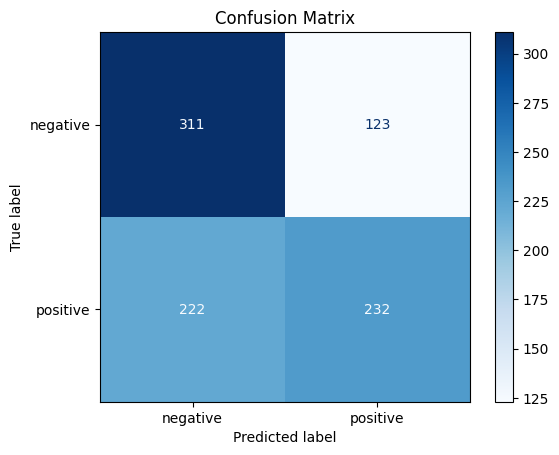

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Extract true and predicted classes from the predictions DataFrame
y_true = predictions_df['true_class']
y_pred = predictions_df['predicted_class']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=target_encoder.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [108]:
from sklearn.metrics import f1_score, accuracy_score

# Extract true and predicted classes from the predictions DataFrame
y_true = predictions_df['true_class']
y_pred = predictions_df['predicted_class']

# Calculate F1 score (set average to 'weighted' if there are multiple classes)
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

F1 Score: 0.61
Accuracy: 0.61


In [ ]:
# Set reliability criteria
min_class_support = 6
min_class_prob_thresholds = [0.6, 0.7, 0.8, 0.9]

In [ ]:
def predict_with_reliability(cluster_classifiers, cluster_data, X, min_class_prob_thresholds):
    class_support = cluster_data['case:Deviant'].value_counts().to_dict()
    if min(class_support.values()) < min_class_support:
        return None, "Insufficient class support"

    # Get prediction probabilities
    pred_probs = cluster_classifiers.predict_proba(X)[0]
    max_prob = np.max(pred_probs)
    predicted_class = cluster_classifiers.predict(X)[0]

    # Check if max probability meets the threshold
    if any(max_prob >= threshold for threshold in min_class_prob_thresholds):
        return predicted_class, "Prediction meets reliability criteria"
    
    return None, "Prediction failure"